# HelmHoltz Decomposition

* [x] ~~HelmHoltz With Capacitance~~
* [ ] Mask Thingy
* [ ] Flux
* [ ] Decomposition in Real Life
* [ ] Multiply everything by the appropriate mask

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
import jax.random as jrandom
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# def solve_helmholtz_dst(rhs, helmholtz_dst):
#     x = dstI2D_torch(rhs.type(helmholtz_dst.dtype)) / helmholtz_dst
#     return F.pad(dstI2D_torch(x),
#                  (1,1,1,1)
#                 ).type(torch.float64)

## Helmholtz Decomposition

### Rectangular Domain

In [3]:
N = 8
nx, ny = 2*2**(N-1), 2*2**(N-1)
shape = (nx, ny)

L = 2_000e3

xc = jnp.linspace(-L, L, nx+1)
yc = jnp.linspace(-L, L, ny+1)

xx, yy = jnp.meshgrid(xc, yc, indexing="ij")

dx = xc[1] - xc[0]
dy = yc[1] - yc[0]

xx.shape

(257, 257)

In [4]:
from jaxsw._src.operators.functional.dst import (
    helmholtz_dst, 
    laplacian_dst, 
    inverse_elliptic_dst, 
    dstI2D, dstI1D,
    inverse_elliptic_dst_cmm,
    helmholtz_fn,
    compute_capacitance_matrices
)

In [5]:
beta = 0.0

H_matrix = laplacian_dst(nx-1, ny-1, dx, dy) - beta

print(H_matrix.shape, xx.shape)

(255, 255) (257, 257)


In [6]:
# create random matrix
key = jrandom.PRNGKey(42)
Frect = jnp.zeros(shape=(nx+1,ny+1))
Frect = Frect.at[1:-1,1:-1].set(jrandom.normal(key=key, shape=(nx-1,ny-1)))

Frect.shape

(257, 257)

In [7]:

Hfrect = helmholtz_fn(Frect, dx, dy, beta)
Hfrect.shape

(255, 255)

#### Solve

In [8]:
Frect_r = inverse_elliptic_dst(Hfrect, H_matrix)
print(Hfrect.shape, Frect_r.shape)

(255, 255) (257, 257)


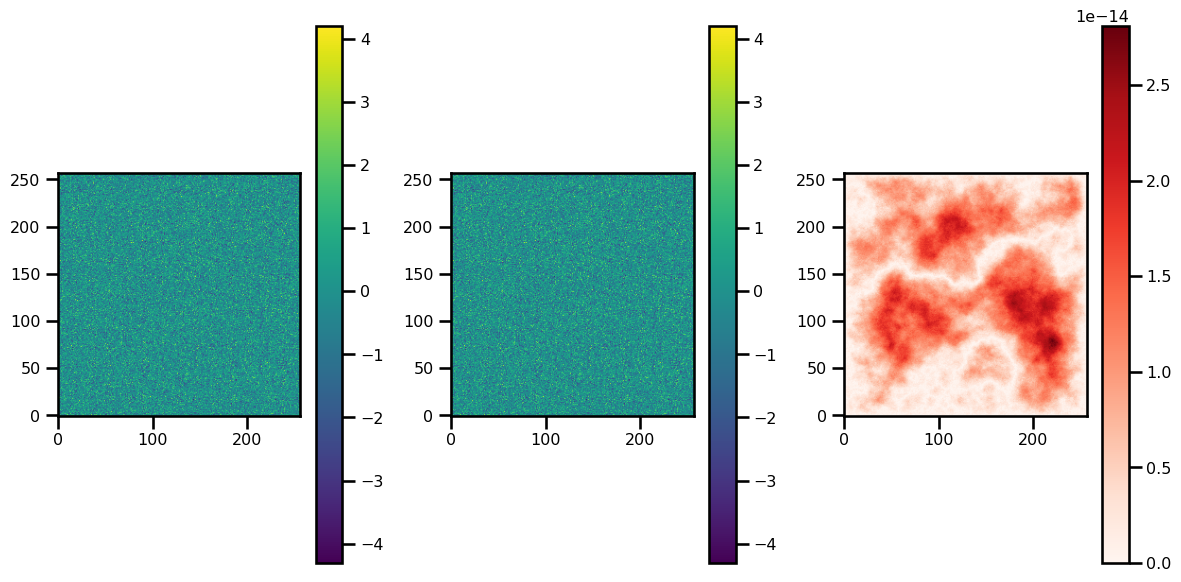

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(12,6))

pts = ax[0].imshow(Frect.T, origin="lower")
plt.colorbar(pts)

pts = ax[1].imshow(Frect_r.T, origin="lower")
plt.colorbar(pts)

pts = ax[2].imshow(np.abs(Frect - Frect_r).T, origin="lower", cmap="Reds")
plt.colorbar(pts)

plt.tight_layout()
plt.show()

### Circular Domain

In [10]:
mask = (1 > ((xx/L)**2 + (yy/L)**2)).astype(jnp.float64)
mask = mask.at[(0,-1),:].set(0.0)
mask = mask.at[(0,-1)].set(0.0)

H_matrix = H_matrix[None, :]

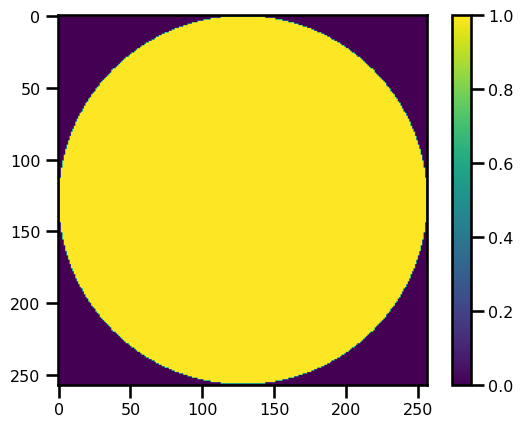

In [11]:
plt.imshow(mask)
plt.colorbar()
plt.show()

In [12]:
# mask_reshape = mask.reshape((1,1)+mask.shape) #NOOOOOO!
mask_reshape = mask[None, None, ...]
mask.shape, mask_reshape.shape

((257, 257), (1, 1, 257, 257))

In [13]:
import kernex as kex

In [14]:
@kex.kmap(kernel_size=(1,1,3,3), strides=1, padding=0)
def avg_pool2d(x):
    return jnp.mean(x)

In [15]:
domain_neighbor = avg_pool2d(mask_reshape)
print(domain_neighbor.sum())
domain_neighbor = domain_neighbor[0,0] > 0

51387.66666666667


In [16]:
# return cond where the mask is less than 0.5 (??) & domain neighbor is...
cond = jnp.logical_and(mask[..., 1:-1,1:-1] < 0.5, domain_neighbor)

# return indices where this is true
irrbound_xids, irrbound_yids = jnp.where(cond)

### Capacitance Matrix Construction

In [17]:
cap_matrices = compute_capacitance_matrices(
    H_matrix, 
    irrbound_xids,
    irrbound_yids
)


#### Inversion Scheme

In [25]:
key = jax.random.PRNGKey(42)

mask_shape = mask.shape
fcirc = mask * jax.random.normal(key=key, shape=mask_shape)
fcirc = fcirc[None,:]

H_matrix = helmholtz_dst(nx-1, ny-1, dx,dy, beta=1.0)[None, :]
Hfcirc = helmholtz_fn(fcirc, dx,dy, 1.0)
Hfcirc *= mask[..., 1:-1,1:-1]
Hfcirc.shape, H_matrix.shape

((1, 255, 255), (1, 255, 255))

In [26]:

# fcirc = fcirc = mask * torch.zeros_like(mask).normal_().unsqueeze(0)
# Hfcirc = helmholtz(fcirc, dx, dy, lambd) * mask[1:-1,1:-1]
# Hfcirc = helmholtz(fcirc, dx, dy, lambd) * mask[1:-1,1:-1]

In [27]:
fcirc.shape, Hfcirc.shape

((1, 257, 257), (1, 255, 255))

In [28]:
fcirc_r = inverse_elliptic_dst_cmm(
    rhs=Hfcirc, H_matrix=H_matrix,
    cap_matrices=cap_matrices,
    bounds_xids=irrbound_xids,
    bounds_yids=irrbound_yids,
    mask=mask
)

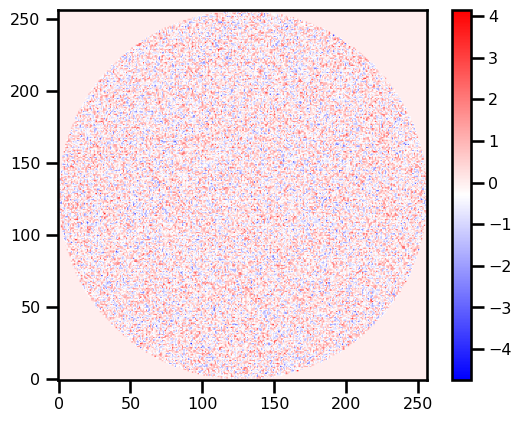

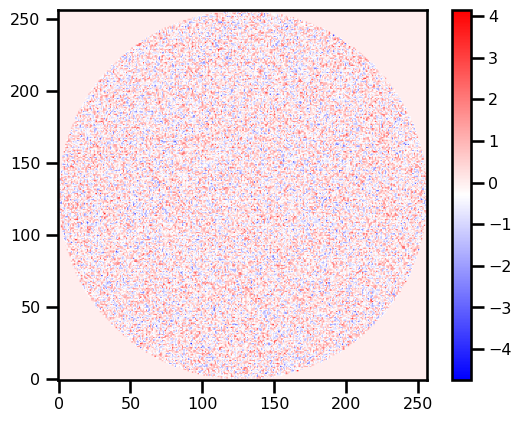

In [29]:
pts = plt.imshow(fcirc_r.T, origin="lower", cmap="bwr")
plt.colorbar(pts)
plt.show()

pts = plt.imshow(fcirc.T, origin="lower", cmap="bwr")
plt.colorbar(pts)
plt.show()

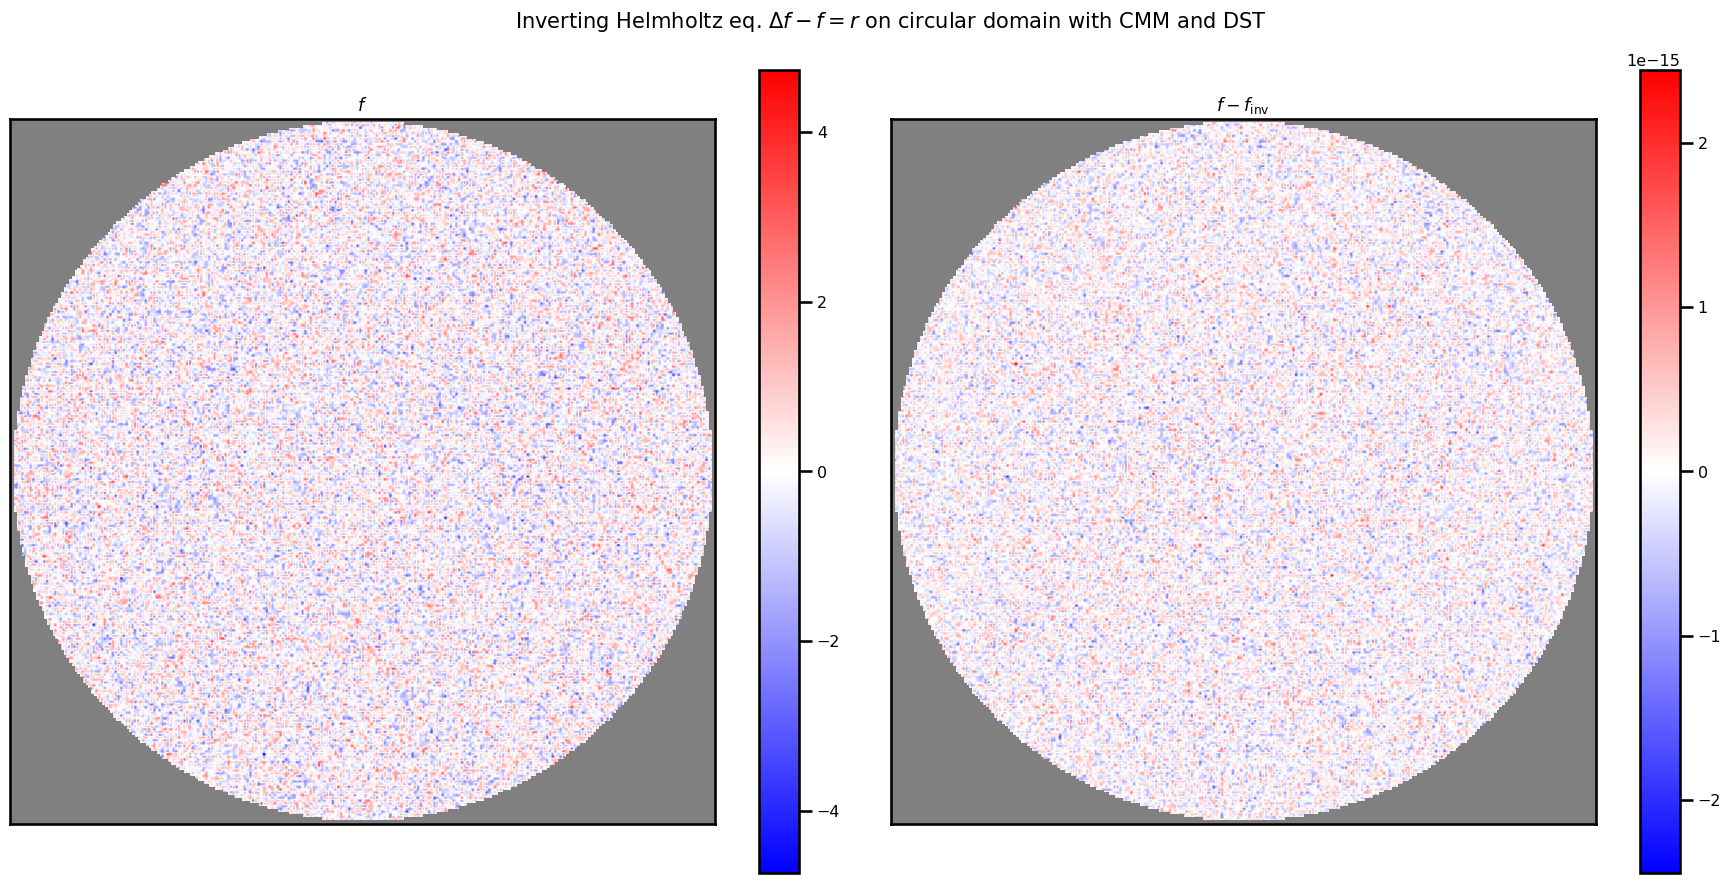

In [30]:
palette = plt.cm.bwr.with_extremes(bad='grey')
fig, ax = plt.subplots(1,2, figsize=(18,9))
ax[0].set_title('$f$')

vM = jnp.abs(fcirc[0]).max()

fcirc_ma = np.ma.masked_where((1-mask), fcirc[0])

fig.colorbar(ax[0].imshow(fcirc_ma.T, vmin=-vM, vmax=vM, origin='lower', cmap=palette), ax=ax[0])
ax[1].set_title('$f - f_{\\rm inv}$')

diff =( fcirc - fcirc_r)[0]

vM = np.abs(diff).max()
diff_ma = np.ma.masked_where((1-mask), diff)

fig.colorbar(ax[1].imshow(diff_ma.T, vmin=-vM, vmax=vM, origin='lower', cmap=palette), ax=ax[1])
fig.suptitle('Inverting Helmholtz eq. $\\Delta f - f = r$ on circular domain with CMM and DST')
ax[0].set_xticks([]), ax[1].set_xticks([]), ax[0].set_yticks([]), ax[1].set_yticks([])
fig.tight_layout()

plt.show()